# Tracking Nanowire Orientation

This notebook begins with a TIFF image of a wire and extracts its orientation. See the end for instructions on how to install the necessary Python packages and run this on your own data.

-- Dan Allan (daniel.b.allan@gmail.com) 11 November 2015

## Overview

1. Import Python packages; load example image.
2. Identify the wire as the largest "blob" in the image.
3. Analyze the image to detect the wire's orientation.
4. Batch process many images and plot orientation over time.

## Step 1: Import Python packages; load example image.

In [1]:
# basics
import numpy as np

# for plotting
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt

# for reading/writing tiff files
import tifffile

# for image analysis
from skimage.filters import sobel
from skimage.morphology import watershed
from scipy import ndimage as ndi

# plotting style
mpl.rcParams['image.cmap'] = 'gray'

/Users/dallan/miniconda/lib/python3.5/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


<IPython.core.display.Javascript object>


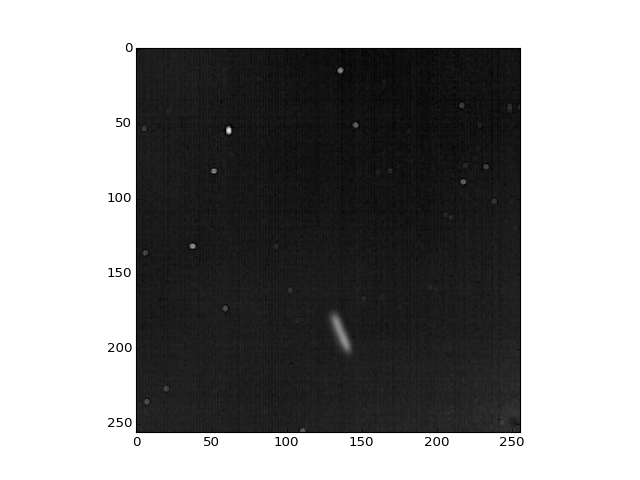

In [2]:
img = tifffile.imread('example-data/frame05.tiff')

# By convention, image analysis filters look for 'bright' things,
# not 'dark' things, so we begin by inverting black and white.
img = np.invert(img)

plt.imshow(img)

## Step 2: Identify the wire as the largest "blob" in the image.

The process of identifying objects in an image is called "segmentation." The code below is closely based on the region-based segmenetation section of [this scikit-image tutorial](http://scikit-image.org/docs/dev/user_guide/tutorial_segmentation.html#region-based-segmentation).

I won't add much commentary here -- read through that tutorial to understand what is being done here.

<IPython.core.display.Javascript object>


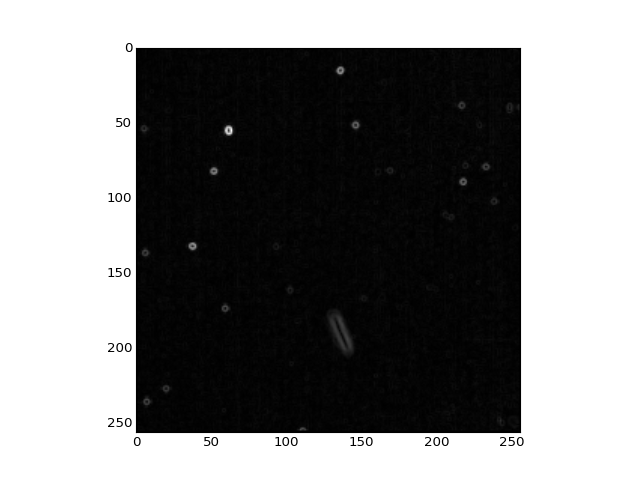

In [3]:
edges = sobel(img)
plt.figure()  # make a new, separate figure
plt.imshow(edges)

<IPython.core.display.Javascript object>


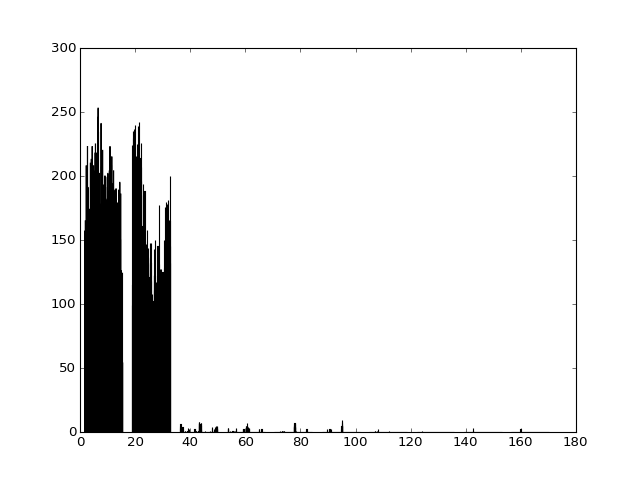

In [4]:
plt.figure()
plt.hist(img);

<IPython.core.display.Javascript object>


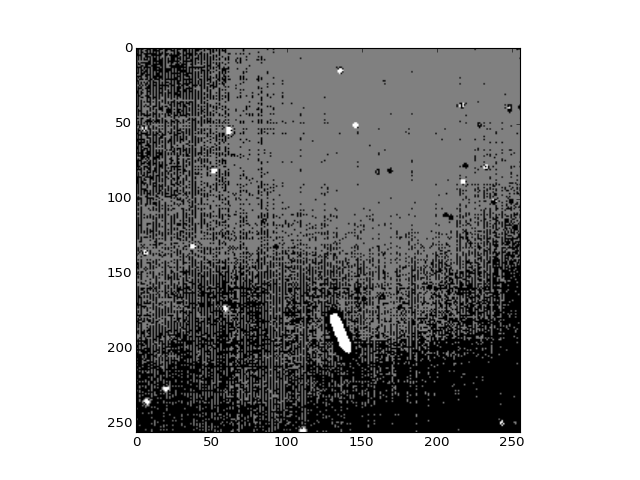

In [5]:
# Fill is roughly the lower and upper extremes of the histogram above.
lower_extreme = 20
upper_extreme = 40

markers = np.zeros_like(img)
markers[img < lower_extreme] = 1
markers[img > upper_extreme] = 2

plt.figure()
plt.imshow(markers)

<IPython.core.display.Javascript object>


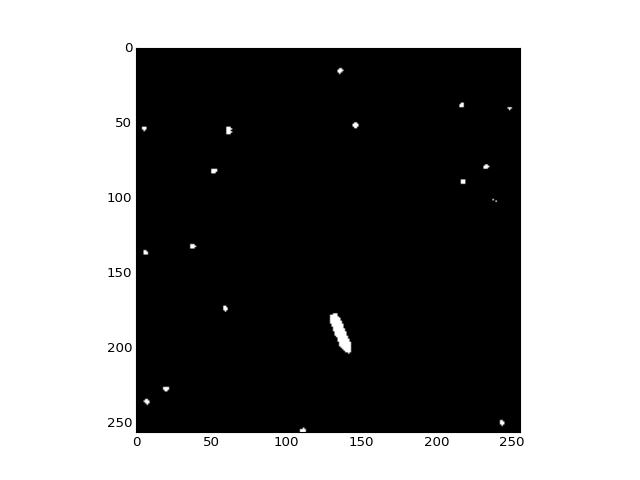

In [6]:
segmentation = watershed(edges, markers)
segmentation = ndi.binary_fill_holes(segmentation - 1)

plt.figure()
plt.imshow(segmentation)

<IPython.core.display.Javascript object>


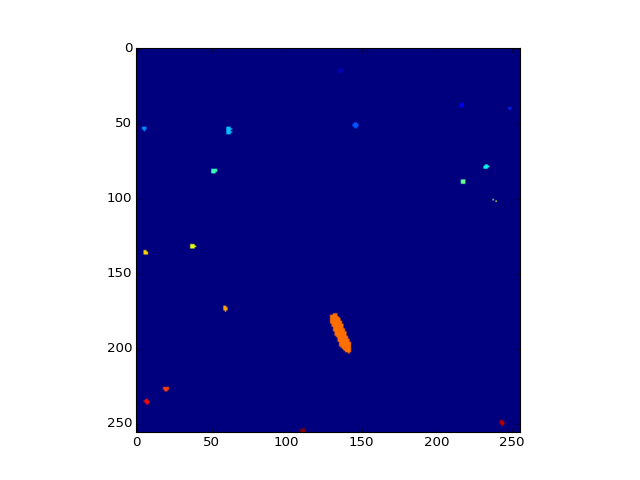

In [7]:
labels, _ = ndi.label(segmentation)

# Each distinct region will be shown in a different color.
plt.figure()
plt.imshow(labels, cmap='jet')

<IPython.core.display.Javascript object>


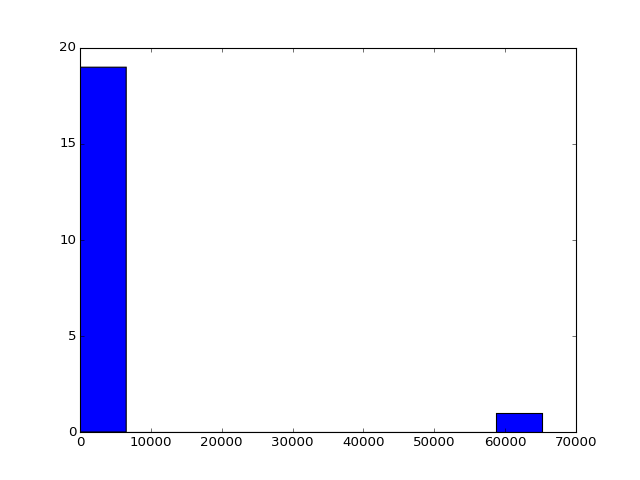

In [8]:
# What is the area of each label?
areas = np.bincount(labels.ravel())

# One hopes there is one label that is obviously bigger than the rest -- corresponding to the wire.
plt.figure()
plt.hist(areas);

<IPython.core.display.Javascript object>


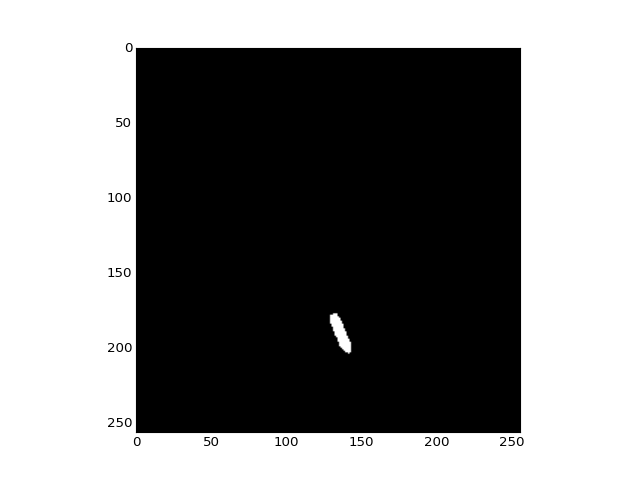

In [9]:
biggest_label = 1 + np.argmax(areas[1:])  # label with the largest area (excluding label 0, the background)
wire_mask = (labels == biggest_label)

# The array 'wire_mask' is True (white) around the wire and False (black) outside it.
plt.figure()
plt.imshow(wire_mask)

<IPython.core.display.Javascript object>


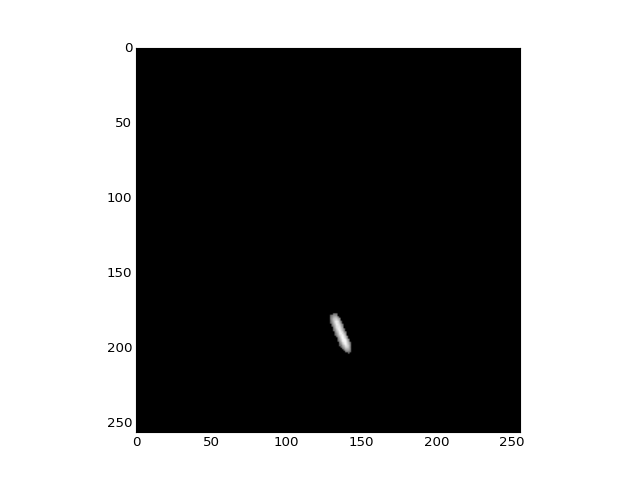

In [10]:
masked_img = wire_mask * img  # In multiplicate True -> 1, False -> 0

plt.figure()
plt.imshow(masked_img)

## Step 3: Analyze the image to detect the wire's orientation

To get the orientation axes of the wire, we'll find the "moments of intentia" of the image. (This is an analogy where brightness is mass.) The cell below defines the functions for finding the moments of inertia. You don't have to follow the details to use them effectively. You can skip to the next cell, where we'll use the functions on our masked image.

Note: I once packaged these functions in a Python package called [needle](http://github.com/danielballan/needle), but I now feel that was overbuilt. All of the actually important and effective code is below.

In [11]:
def moment(img, i, j):
    """
    A utility function called by inertial_axes.
    
    See that function, below, for attribution and usage.
    """
    nrows, ncols = img.shape
    y, x = np.mgrid[:nrows, :ncols]
    return (img * x**i * y**j).sum()

def inertial_axes(img):
    """Calculate the x-mean, y-mean, and cov matrix of an image.
    
    Parameters
    ----------
    img: ndarray
    
    Returns
    -------
    xbar, ybar, cov 
        center in x, center in y, covariance matrix

    Attribution
    -----------
    This function is based on a solution by Joe Kington, posted on Stack
    Overflow at
    
    http://stackoverflow.com/questions/5869891/how-to-calculate-the-axis-of-orientation/5873296#5873296
    """
    normalization = np.sum(img)
    m10 = moment(img, 1, 0)
    m01 = moment(img, 0, 1)
    x_bar = m10 / normalization
    y_bar = m01 / normalization
    u11 = (moment(img, 1, 1) - x_bar * m01) / normalization
    u20 = (moment(img, 2, 0) - x_bar * m10) / normalization
    u02 = (moment(img, 0, 2) - y_bar * m01) / normalization
    cov = np.array([[u20, u11], [u11, u02]])
    return x_bar, y_bar, cov

def orientation(cov):
    """Compute the orientation angle of the dominant eigenvector of
    a covariance matrix.

    Parameters
    ----------
    cov: 2x2 array

    Returns
    -------
    angle in radians
    """
    eigvals, eigvecs = np.linalg.eigh(cov)
    principal_moment = eigvecs[eigvals.argmax()]
    return np.arctan2(principal_moment[1], principal_moment[0])

def plot_principal_axes(img, x_bar, y_bar, cov):
    """Plot bars with a length of 2 stddev along the principal axes.

    Attribution
    -----------
    This function is based on a solution by Joe Kington, posted on Stack
    Overflow at http://stackoverflow.com/questions/5869891/
    how-to-calculate-the-axis-of-orientation/5873296#5873296
    """
    ax = plt.gca()  # current axes
    def make_lines(eigvals, eigvecs, mean, i):
        """Make lines a length of 2 stddev."""
        std = np.sqrt(eigvals[i])
        vec = 2 * std * eigvecs[:,i] / np.hypot(*eigvecs[:,i])
        x, y = np.vstack((mean-vec, mean, mean+vec)).T
        return x, y
    mean = np.array([x_bar, y_bar])
    eigvals, eigvecs = np.linalg.eigh(cov)
    ax.plot(*make_lines(eigvals, eigvecs, mean, 0), marker='o', color='white')
    ax.plot(*make_lines(eigvals, eigvecs, mean, -1), marker='o', color='red')
    ax.imshow(img)

Below, we compute the inertial axes and the orientation. We plot the axes on top of the original (unprocessed) image, and we print the orientation in degrees.

**In a live notebook, use the "box zoom" feature (second button from the right) to take a closer look at how well the axes annotation lines up with the image of the wire.**

<IPython.core.display.Javascript object>


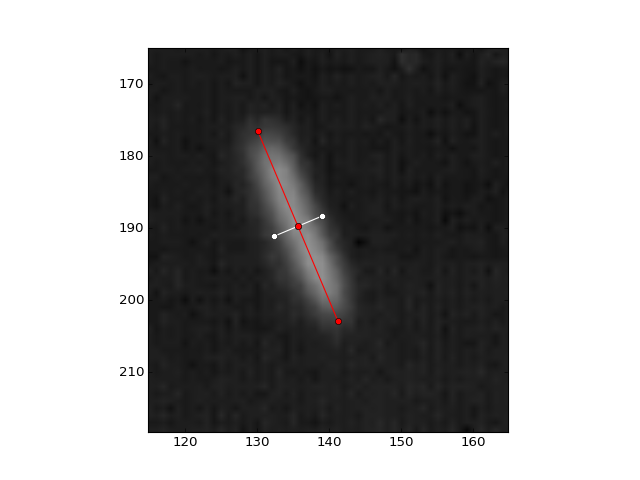

67.1365620403 degrees


In [12]:
x_bar, y_bar, cov = inertial_axes(masked_img)
rad = orientation(cov)  # orientation in radians
deg = np.rad2deg(rad)

plt.figure()
plot_principal_axes(img, x_bar, y_bar, cov)
print(deg, 'degrees')

## Step 4: Batch process many images and plot orientation over time

Before we begin, we'll express the process in Step 1 as a function.

In [13]:
def mask_image(img, lower_extreme, upper_extreme):
    """
    See the section Step 1 for explanation.
    
    If this fails on a given image, use the step-by-step approach to debug.
    """
    edges = sobel(img)
    
    markers = np.zeros_like(img)
    markers[img < lower_extreme] = 1
    markers[img > upper_extreme] = 2
    
    segmentation = watershed(edges, markers)
    segmentation = ndi.binary_fill_holes(segmentation - 1)
    
    labels, _ = ndi.label(segmentation)
    areas = np.bincount(labels.ravel())
    biggest_label = 1 + np.argmax(areas[1:])  # label with the largest area (excluding label 0, the background)
    
    wire_mask = (labels == biggest_label)
    masked_img = wire_mask * img
    return masked_img

In [14]:
import pims

images = pims.ImageSequence('example-data/*tiff')

In [15]:
results = []

for img in images:
    img = np.invert(img)
    masked_img = mask_image(img, 20, 40)
    x_bar, y_bar, cov = inertial_axes(masked_img)
    rad = orientation(cov)  # orientation in radians
    deg = np.rad2deg(rad)
    results.append(deg)
    
# Retrict to the domain [1, 180] for better plotting.
results = np.mod(results, 180)

<IPython.core.display.Javascript object>


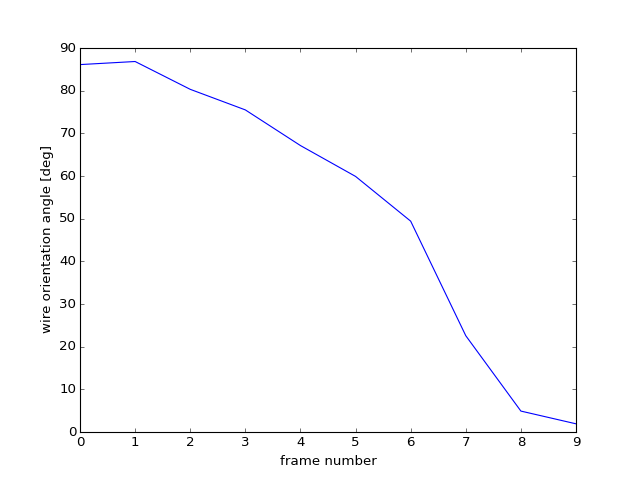

In [16]:
plt.figure()
plt.plot(results)
plt.xlabel('frame number')
plt.ylabel('wire orientation angle [deg]')

## How to run this notebook on your own data

This command:
1. Install [conda](http://conda.pydata.org/docs/download.html#should-i-download-anaconda-or-miniconda).
2. Download this repository (including this notebook, example data, and a list of required Python packages). You can clone it from the [github repository](https://github.com/danielballan/wire-tracking-tutorial/) or simply download it as a [zip file](https://github.com/danielballan/wire-tracking-tutorial/archive/master.zip).
3. Open a terminal (command prompt) and use `cd` to change to the directory where these files are downloaded.
4. Install the required Python packages into a new "environment":
  ```
  conda-env create environment.yml
  ```
5. Activate* the new environment.
  ```
  activate wire-env
  ```
6. Start a Jupyter notebook (formerly called IPython notebook) which can be used to run this tutorial.

  ```
  jupyter notebook
  ```

(*On a Mac or a Linux machine, the command is ``source activate wire-env`` in place of ``activate wire-env``.)